In [12]:
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../../')
from src.Task import *
import numpy as np
np.set_printoptions(suppress=True)
import os
import sys
import json
from copy import deepcopy
import pandas as pd
import datetime


In [238]:

def ReLU(x):
    return np.maximum(x, 0)


class RNN_numpy_test():
    def __init__(self, N, dt, tau, W_inp, W_rec, W_out, activation=ReLU):
        self.N = N
        self.W_inp = W_inp
        self.W_rec = W_rec
        self.W_out = W_out
        self.dt = dt
        self.tau = tau
        self.alpha = self.dt / self.tau
        self.y_init = np.zeros(self.N)
        self.y = deepcopy(self.y_init)
        self.h = W_rec @ deepcopy(self.y)
        self.y_history = []
        self.h_history = []
        self.inputs = [np.zeros(6)]
        self.activation = activation


    def rhs(self, y, h, input):
        rhs_y = -y + self.activation(self.W_rec @ y + self.W_inp @ input)
        rhs_h = -h + W_rec @ self.activation(h) + self.W_inp @ input
        return rhs_y, rhs_h

    def step(self, input):
        # if the input experiences a sudden jump then h is updated first
        if not np.product(self.inputs[-1] == input): 
            delta_h = W_inp @ (input - self.inputs[-1])
            self.h += delta_h
            h = deepcopy(self.h)
        # afterwards the variabes are updated as usual
        rhs_y, rhs_h = self.rhs(self.y, self.h, input)
        self.y += (self.dt / self.tau) * rhs_y
        self.h += (self.dt / self.tau) * rhs_h


    def run(self, input_timeseries, save_history=False):
        '''
        :param Inputs: an array, has to be iether (n_inputs x n_steps) dimensions or (n_inputs x n_steps x batch_batch_size)
        :param save_history: bool, whether to save the resulting trajectory
        :return: None
        '''
        num_steps = input_timeseries.shape[1]  # second dimension
        self.h = self.W_rec @ self.y + self.W_inp @ input_timeseries[:, 0, ...]
        self.inputs.append(deepcopy(input_timeseries[:, 0, ...]))
        for i in range(num_steps):
            self.step(input_timeseries[:, i, ...])
            self.inputs.append(deepcopy(input_timeseries[:, i, ...]))
            if save_history == True:
                self.y_history.append(deepcopy(self.y))
                self.h_history.append(deepcopy(self.h))
        return None

    def get_history(self):
        return np.swapaxes(np.array(self.y_history), 0, 1), np.swapaxes(np.array(self.h_history), 0, 1)

    def clear_history(self):
        self.y_history = []
        self.h_history = []
        self.inputs = [np.zeros(6)]

    def reset_state(self):
        self.y = np.zeros(self.N)
        self.h = W_rec @ deepcopy(self.y)
        self.inputs = [np.zeros(6)]

    def get_output(self):
        y_history = np.stack(self.y_history, axis=0)
        output = np.swapaxes((self.W_out @ y_history), 0, 1)
        return output

In [239]:
# load some RNN
task_name = "CDDM"
RNNs_path = os.path.join('../', "data", "trained_RNNs", task_name)
RNN_subfolder = '0.0070617_CDDM;relu;N=90;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000'
RNN_score = 0.0070617
RNN_path = os.path.join(RNNs_path, RNN_subfolder)
RNN_data = json.load(open(os.path.join(RNN_path, f"{RNN_score}_params_{task_name}.json"), "rb+"))
RNN_config_file = json.load(open(os.path.join(RNN_path, f"{RNN_score}_config.json"), "rb+"))
W_out = np.array(RNN_data["W_out"])
W_rec = np.array(RNN_data["W_rec"])
W_inp = np.array(RNN_data["W_inp"])
bias_rec = np.array(RNN_data["bias_rec"])
y_init = np.array(RNN_data["y_init"])
activation = RNN_config_file["activation"]
mask = np.array(RNN_config_file["mask"])
input_size = RNN_config_file["num_inputs"]
output_size = RNN_config_file["num_outputs"]
task_params = RNN_config_file["task_params"]
n_steps = task_params["n_steps"]
sigma_inp = RNN_config_file["sigma_inp"]
sigma_rec = RNN_config_file["sigma_rec"]
dt = RNN_config_file["dt"]
tau = RNN_config_file["tau"]

rnn = RNN_numpy_test(N=W_rec.shape[0], W_rec=W_rec, W_inp=W_inp, W_out=W_out, dt=dt, tau=tau, activation=lambda x: np.maximum(0, x))

In [240]:
task_params = {"cue_on" : 0, "cue_off": 750, "stim_on" : 250, "stim_off": 750, "dec_on" : 500, "dec_off": 750, "seed" : 0, "coherences" : [-0.8, -0.4, -0.2, 0, 0.2, 0.4, 0.8]}
task = TaskCDDM(n_steps=750, n_inputs=6, n_outputs=2, task_params=task_params)


In [241]:
# run the dynamics of the RNN
input_batch, target_batch, conditions_batch = task.get_batch()

In [242]:
errs = []
for k in range(input_batch.shape[-1]):
    input = input_batch[..., k]
    target = target_batch[..., k]
    condition = conditions_batch[k]
    rnn.clear_history()
    rnn.run(input, save_history=True)
    
    
    ys, hs = rnn.get_history()
    hs_hat = W_rec @ ys + W_inp @ input
    err = np.mean((hs_hat - hs)**2)
    errs.append(deepcopy(err))

<StemContainer object of 3 artists>

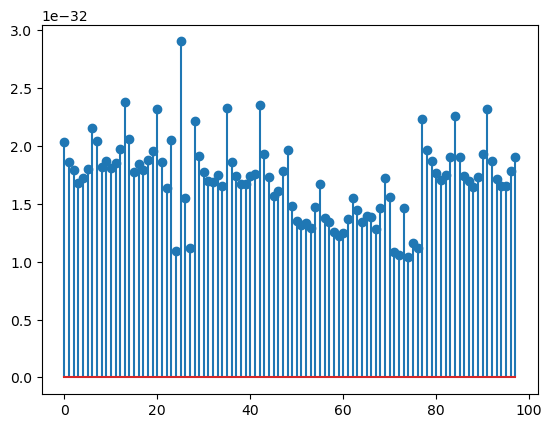

In [243]:
from matplotlib import pyplot as plt
plt.stem(errs)

In [244]:
k = 65
input = input_batch[..., k]
target = target_batch[..., k]
condition = conditions_batch[k]

rnn.clear_history()
rnn.run(input, save_history=True)
ys, hs = rnn.get_history()
hs_hat = W_rec @ ys + W_inp @ input
var = W_rec @ ys 
err = np.mean((hs_hat - hs)**2)
print(err)

1.4323599470508873e-32


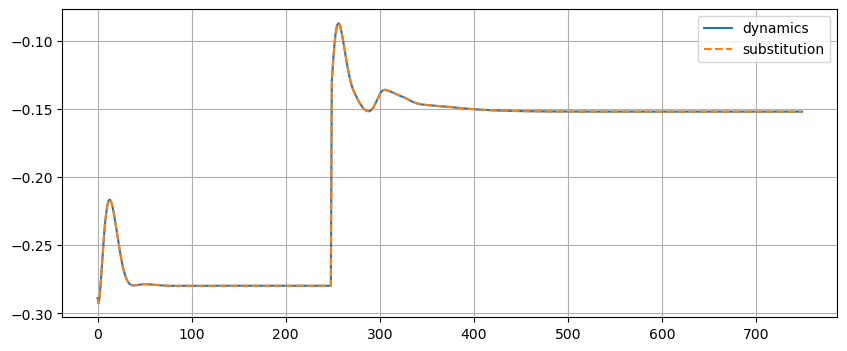

In [246]:
num_nrn = 7
fig = plt.figure(figsize = (10, 4))
plt.plot(hs[num_nrn, :], label='dynamics')
plt.plot(hs_hat[num_nrn, :], linestyle='--', label='substitution')
plt.legend(loc=1)
plt.grid(True)
plt.show()